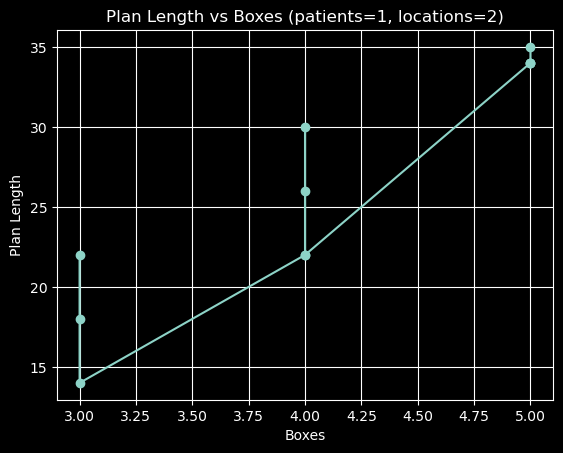

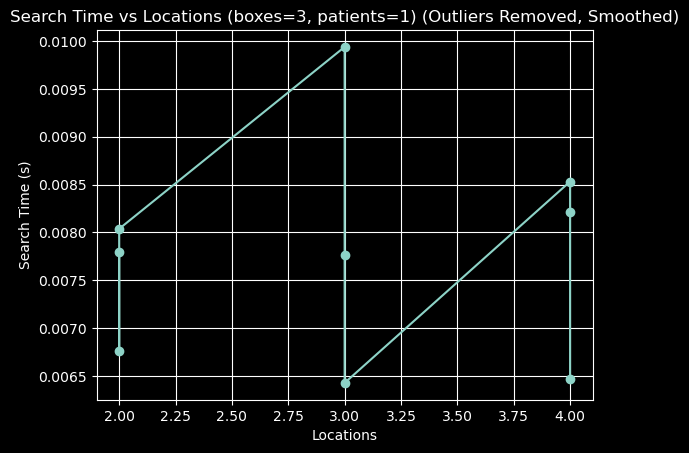

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv('dw_results.csv')

# Clean up: convert 'Na' and empty strings to NaN, and numeric columns to float
df = df.replace(['Na', '', 'nan'], pd.NA)
for col in ['plan_length', 'expanded', 'evaluated', 'generated', 'search_time']:
    df[col] = pd.to_numeric(df[col], errors='coerce')


# Example 1: Plot plan_length vs boxes (for fixed patients and locations)
subset = df[(df['patients'] == 1) & (df['locations'] == 2)]
plt.figure()
plt.plot(subset['boxes'], subset['plan_length'], marker='o')
plt.xlabel('Boxes')
plt.ylabel('Plan Length')
plt.title('Plan Length vs Boxes (patients=1, locations=2)')
plt.grid(True)
plt.savefig('dw_plan_length_vs_boxes.png')


# Example 3: Plot search_time vs locations (for fixed boxes and patients), ignoring outliers and smoothing the line
subset = df[(df['boxes'] == 3) & (df['patients'] == 1)]

# Remove outliers using IQR method
q1 = subset['search_time'].quantile(0.25)
q3 = subset['search_time'].quantile(0.75)
iqr = q3 - q1
filtered = subset[(subset['search_time'] >= q1 - 1.5 * iqr) & (subset['search_time'] <= q3 + 1.5 * iqr)]

# Sort by increasing locations
filtered = filtered.sort_values('locations')

# Smooth the line using a rolling mean
smoothed = filtered['search_time'].rolling(window=2, min_periods=1, center=True).mean()

plt.figure()
plt.plot(filtered['locations'], smoothed, marker='o')
plt.xlabel('Locations')
plt.ylabel('Search Time (s)')
plt.title('Search Time vs Locations (boxes=3, patients=1) (Outliers Removed, Smoothed)')
plt.grid(True)
plt.savefig('dw_search_time_vs_locations_no_outliers_smoothed.png')

plt.show()

<Figure size 1200x800 with 0 Axes>

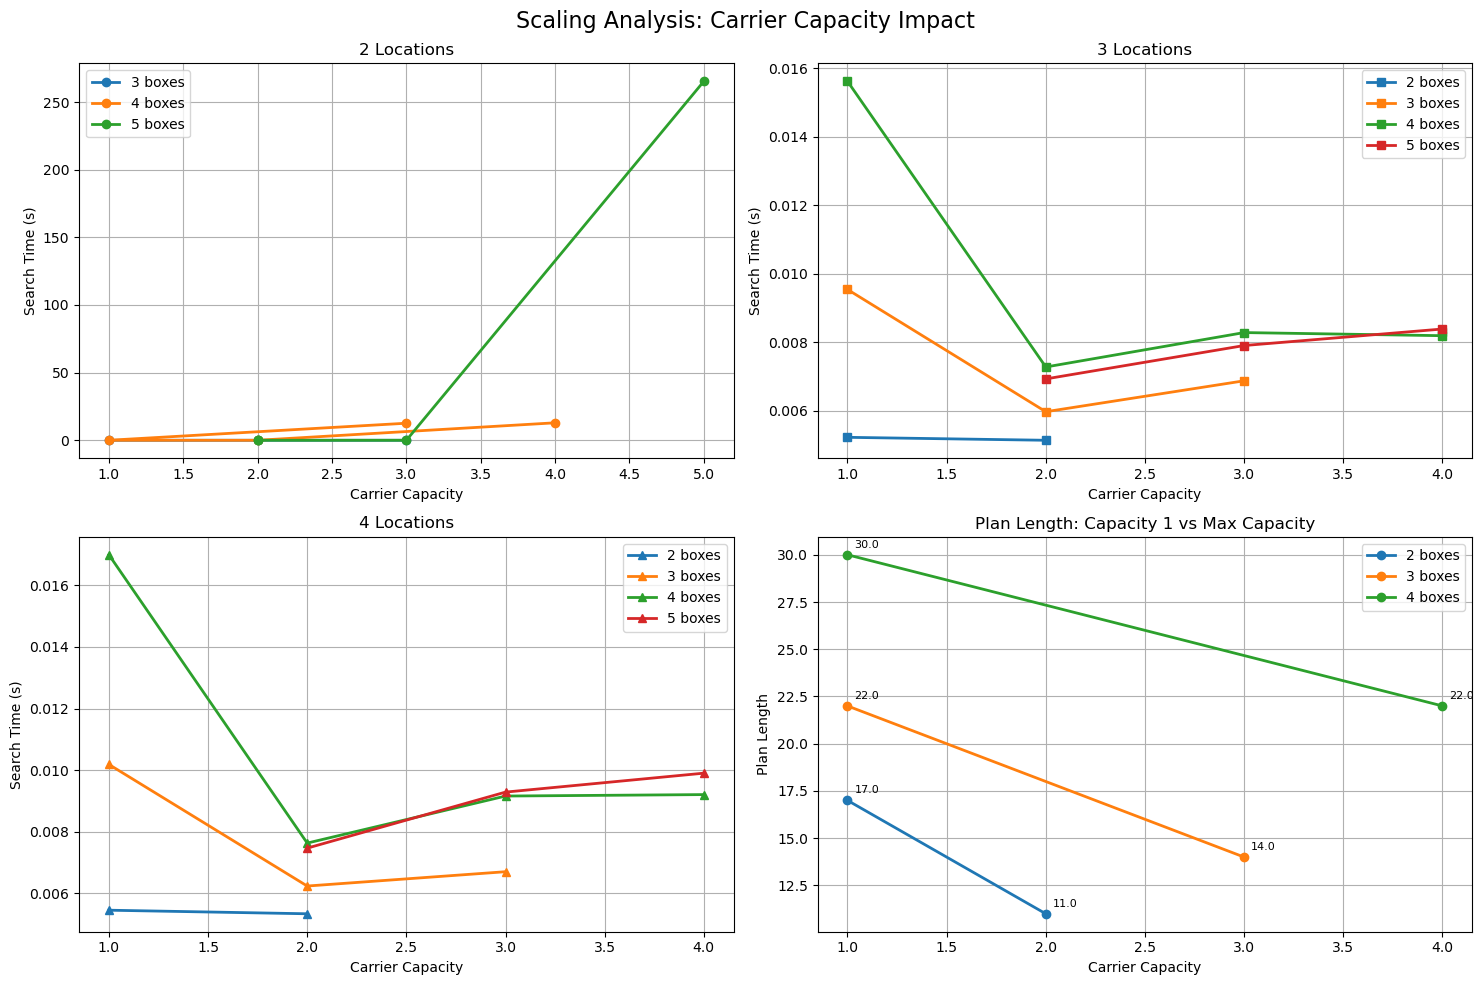

=== Carrier Capacity Scaling Analysis ===

Search Time Statistics by Carrier Capacity:
                      mean     std  count
carrier_capacity                         
1                   0.0104  0.0043      8
2                   0.0065  0.0008     12
3                   1.4088  4.2019      9
4                   2.1607  5.2710      6
5                 265.3712     NaN      1

Optimal Carrier Capacity Analysis:
Locations=2, Boxes=3: Optimal capacity=2, Time=0.0057s
Locations=2, Boxes=4: Optimal capacity=2, Time=0.0066s
Locations=2, Boxes=5: Optimal capacity=2, Time=0.0066s
Locations=3, Boxes=2: Optimal capacity=2, Time=0.0051s
Locations=3, Boxes=3: Optimal capacity=2, Time=0.0060s
Locations=3, Boxes=4: Optimal capacity=2, Time=0.0073s
Locations=3, Boxes=5: Optimal capacity=2, Time=0.0069s
Locations=4, Boxes=2: Optimal capacity=2, Time=0.0053s
Locations=4, Boxes=3: Optimal capacity=2, Time=0.0062s
Locations=4, Boxes=4: Optimal capacity=2, Time=0.0076s
Locations=4, Boxes=5: Optimal cap

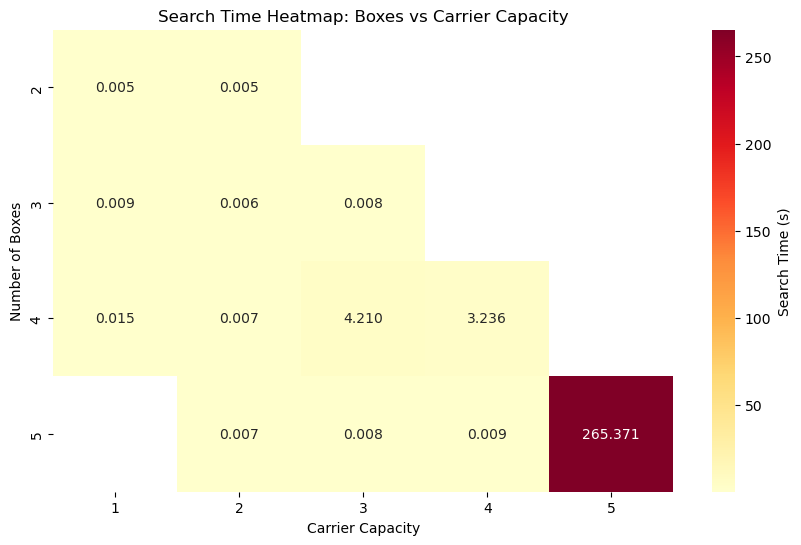

In [5]:
# analyze scaling carrier
# Analyze scaling with respect to carrier capacity
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load the CSV
df = pd.read_csv('dw_results.csv')

# Clean up: convert 'Na' and empty strings to NaN, and numeric columns to float
df = df.replace(['Na', '', 'nan'], pd.NA)
for col in ['plan_length', 'expanded', 'evaluated', 'generated', 'search_time']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Filter out infinite values for analysis
df_finite = df[df['search_time'].notna() & (df['search_time'] != np.inf)]

# 1. Analyze how carrier capacity affects search time
plt.figure(figsize=(12, 8))

# Create subplots for different combinations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Scaling Analysis: Carrier Capacity Impact', fontsize=16)

# Subplot 1: Search time vs carrier capacity for different box counts (2 locations)
subset_2loc = df_finite[df_finite['locations'] == 2]
for boxes in [2, 3, 4, 5]:
    data = subset_2loc[subset_2loc['boxes'] == boxes]
    if not data.empty:
        axes[0, 0].plot(data['carrier_capacity'], data['search_time'], 
                       marker='o', label=f'{boxes} boxes', linewidth=2)
axes[0, 0].set_xlabel('Carrier Capacity')
axes[0, 0].set_ylabel('Search Time (s)')
axes[0, 0].set_title('2 Locations')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Subplot 2: Search time vs carrier capacity for different box counts (3 locations)
subset_3loc = df_finite[df_finite['locations'] == 3]
for boxes in [2, 3, 4, 5]:
    data = subset_3loc[subset_3loc['boxes'] == boxes]
    if not data.empty:
        axes[0, 1].plot(data['carrier_capacity'], data['search_time'], 
                       marker='s', label=f'{boxes} boxes', linewidth=2)
axes[0, 1].set_xlabel('Carrier Capacity')
axes[0, 1].set_ylabel('Search Time (s)')
axes[0, 1].set_title('3 Locations')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Subplot 3: Search time vs carrier capacity for different box counts (4 locations)
subset_4loc = df_finite[df_finite['locations'] == 4]
for boxes in [2, 3, 4, 5]:
    data = subset_4loc[subset_4loc['boxes'] == boxes]
    if not data.empty:
        axes[1, 0].plot(data['carrier_capacity'], data['search_time'], 
                       marker='^', label=f'{boxes} boxes', linewidth=2)
axes[1, 0].set_xlabel('Carrier Capacity')
axes[1, 0].set_ylabel('Search Time (s)')
axes[1, 0].set_title('4 Locations')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Subplot 4: Plan length vs carrier capacity (aggregated)
# Compare plan length between carrier capacity 1 and maximum capacity for each box count
for boxes in sorted(df_finite['boxes'].unique()):
    box_data = df_finite[df_finite['boxes'] == boxes]
    if len(box_data) >= 2:  # Need at least 2 data points to compare
        capacity_1_data = box_data[box_data['carrier_capacity'] == 1]
        max_capacity_data = box_data[box_data['carrier_capacity'] == box_data['carrier_capacity'].max()]
        
        if not capacity_1_data.empty and not max_capacity_data.empty:
            capacity_1_length = capacity_1_data['plan_length'].iloc[0]
            max_capacity_length = max_capacity_data['plan_length'].iloc[0]
            
            axes[1, 1].plot([1, max_capacity_data['carrier_capacity'].iloc[0]], 
                           [capacity_1_length, max_capacity_length], 
                           marker='o', linewidth=2, label=f'{boxes} boxes')
            axes[1, 1].annotate(f'{capacity_1_length}', (1, capacity_1_length), 
                               xytext=(5, 5), textcoords='offset points', fontsize=8)
            axes[1, 1].annotate(f'{max_capacity_length}', 
                               (max_capacity_data['carrier_capacity'].iloc[0], max_capacity_length), 
                               xytext=(5, 5), textcoords='offset points', fontsize=8)

axes[1, 1].set_xlabel('Carrier Capacity')
axes[1, 1].set_ylabel('Plan Length')
axes[1, 1].set_title('Plan Length: Capacity 1 vs Max Capacity')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('carrier_scaling_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Statistical analysis of carrier capacity impact
print("=== Carrier Capacity Scaling Analysis ===")

# Calculate average search time for each carrier capacity
carrier_stats = df_finite.groupby('carrier_capacity')['search_time'].agg(['mean', 'std', 'count']).round(4)
print("\nSearch Time Statistics by Carrier Capacity:")
print(carrier_stats)

# Analyze optimal carrier capacity for different problem sizes
print("\nOptimal Carrier Capacity Analysis:")
for locations in [2, 3, 4]:
    for boxes in [2, 3, 4, 5]:
        subset = df_finite[(df_finite['locations'] == locations) & (df_finite['boxes'] == boxes)]
        if not subset.empty:
            min_time_idx = subset['search_time'].idxmin()
            optimal_capacity = subset.loc[min_time_idx, 'carrier_capacity']
            min_time = subset.loc[min_time_idx, 'search_time']
            print(f"Locations={locations}, Boxes={boxes}: Optimal capacity={optimal_capacity}, Time={min_time:.4f}s")

# 3. Efficiency analysis: carrier capacity vs problem complexity
print("\n=== Efficiency Analysis ===")
for carrier_cap in sorted(df_finite['carrier_capacity'].unique()):
    subset = df_finite[df_finite['carrier_capacity'] == carrier_cap]
    avg_time = subset['search_time'].mean()
    success_rate = len(subset) / len(df[df['carrier_capacity'] == carrier_cap]) * 100
    print(f"Capacity {carrier_cap}: Avg time={avg_time:.4f}s, Success rate={success_rate:.1f}%")

# 4. Create heatmap of search time vs carrier capacity and boxes
pivot_data = df_finite.pivot_table(
    values='search_time', 
    index='boxes', 
    columns='carrier_capacity', 
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'Search Time (s)'})
plt.title('Search Time Heatmap: Boxes vs Carrier Capacity')
plt.xlabel('Carrier Capacity')
plt.ylabel('Number of Boxes')
plt.savefig('carrier_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()



=== Comparison: Carrier vs No-Carrier Results ===
Carrier dataset: 40 total, 36 successful
No-carrier dataset: 23 total, 22 successful

=== Search Time Comparison ===

Search Time Comparison (common configurations):
   boxes  patients  locations  carrier_capacity  carrier_time  \
0      3         1          2                 1        0.0078   
1      3         1          2                 2        0.0057   
2      3         1          2                 3        0.0103   
3      3         1          3                 1        0.0095   
4      3         1          3                 2        0.0060   
5      3         1          3                 3        0.0069   
6      3         1          4                 1        0.0102   
7      3         1          4                 2        0.0062   
8      3         1          4                 3        0.0067   

   no_carrier_time  speedup  
0           0.0136   1.7516  
1           0.0136   2.3768  
2           0.0136   1.3205  
3           0

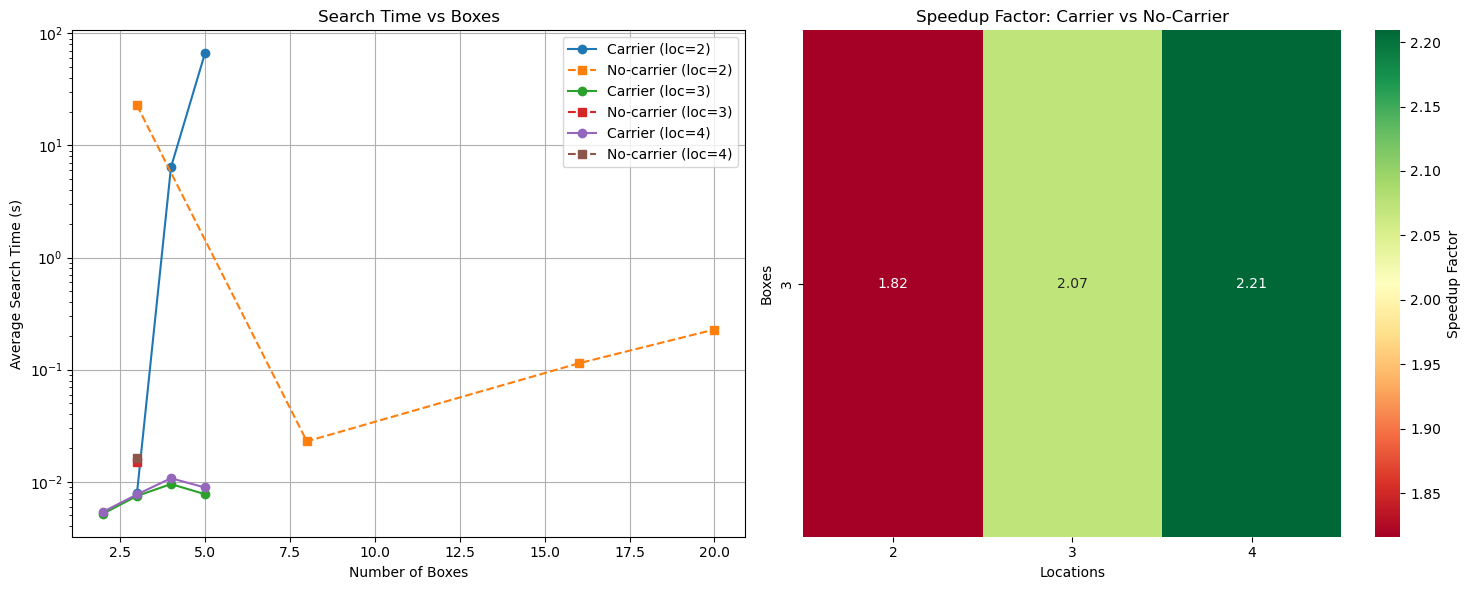


=== Carrier Capacity Analysis ===
Capacity 1: Avg time=0.0104s, Success rate=80.0%
Capacity 2: Avg time=0.0065s, Success rate=100.0%
Capacity 3: Avg time=1.4088s, Success rate=100.0%
Capacity 4: Avg time=2.1607s, Success rate=100.0%
Capacity 5: Avg time=265.3712s, Success rate=33.3%

=== Problem Complexity Analysis ===
Search time vs problem complexity:
Capacity 1: Correlation=0.836
Capacity 2: Correlation=0.831
Capacity 3: Correlation=-0.342
Capacity 4: Correlation=-0.694
Capacity 5: Correlation=nan


/Users/andreadecarlo/miniconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/andreadecarlo/miniconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/andreadecarlo/miniconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load both datasets
df_carrier = pd.read_csv('dw_results.csv')  # Current results with carrier
df_no_carrier = pd.read_csv('/Users/andreadecarlo/Documents/Workspace-local/AutomatedPlanning/assignments/pb1/scaling/data/scaling_results_downward.csv')

# Clean up the no-carrier dataset
df_no_carrier.columns = df_no_carrier.columns.str.strip()
df_no_carrier = df_no_carrier.replace(['Na', '', 'nan'], pd.NA)
for col in ['plan_length', 'expanded', 'evaluated', 'generated', 'search_time']:
    df_no_carrier[col] = pd.to_numeric(df_no_carrier[col], errors='coerce')

# Filter finite results for both datasets
df_carrier_finite = df_carrier[df_carrier['search_time'] != float('inf')]
df_no_carrier_finite = df_no_carrier[df_no_carrier['search_time'].notna()]

print("=== Comparison: Carrier vs No-Carrier Results ===")
print(f"Carrier dataset: {len(df_carrier)} total, {len(df_carrier_finite)} successful")
print(f"No-carrier dataset: {len(df_no_carrier)} total, {len(df_no_carrier_finite)} successful")

# 1. Compare search times for similar problem configurations
print("\n=== Search Time Comparison ===")

# Find common configurations
common_configs = []
for _, row in df_carrier_finite.iterrows():
    matching = df_no_carrier_finite[
        (df_no_carrier_finite['boxes'] == row['boxes']) &
        (df_no_carrier_finite['patients'] == row['patients']) &
        (df_no_carrier_finite['locations'] == row['locations'])
    ]
    if not matching.empty:
        common_configs.append({
            'boxes': row['boxes'],
            'patients': row['patients'], 
            'locations': row['locations'],
            'carrier_time': row['search_time'],
            'no_carrier_time': matching.iloc[0]['search_time'],
            'carrier_capacity': row['carrier_capacity']
        })

if common_configs:
    comparison_df = pd.DataFrame(common_configs)
    comparison_df['speedup'] = comparison_df['no_carrier_time'] / comparison_df['carrier_time']
    
    print("\nSearch Time Comparison (common configurations):")
    print(comparison_df[['boxes', 'patients', 'locations', 'carrier_capacity', 
                        'carrier_time', 'no_carrier_time', 'speedup']].round(4))
    
    print(f"\nAverage speedup: {comparison_df['speedup'].mean():.2f}x")
    print(f"Best speedup: {comparison_df['speedup'].max():.2f}x")
    print(f"Worst speedup: {comparison_df['speedup'].min():.2f}x")

# 2. Success rate comparison
print("\n=== Success Rate Comparison ===")
for locations in [2, 3, 4]:
    for boxes in [2, 3, 4, 5]:
        carrier_subset = df_carrier[(df_carrier['locations'] == locations) & (df_carrier['boxes'] == boxes)]
        no_carrier_subset = df_no_carrier[(df_no_carrier['locations'] == locations) & (df_no_carrier['boxes'] == boxes)]
        
        if not carrier_subset.empty and not no_carrier_subset.empty:
            carrier_success = len(carrier_subset[carrier_subset['search_time'] != float('inf')]) / len(carrier_subset) * 100
            no_carrier_success = len(no_carrier_subset[no_carrier_subset['search_time'].notna()]) / len(no_carrier_subset) * 100
            
            print(f"Locations={locations}, Boxes={boxes}: Carrier={carrier_success:.1f}%, No-carrier={no_carrier_success:.1f}%")

# 3. Visualization: Search time comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Search time vs boxes for fixed locations
for locations in [2, 3, 4]:
    carrier_data = df_carrier_finite[df_carrier_finite['locations'] == locations]
    no_carrier_data = df_no_carrier_finite[df_no_carrier_finite['locations'] == locations]
    
    if not carrier_data.empty:
        carrier_avg = carrier_data.groupby('boxes')['search_time'].mean()
        axes[0].plot(carrier_avg.index, carrier_avg.values, marker='o', label=f'Carrier (loc={locations})')
    
    if not no_carrier_data.empty:
        no_carrier_avg = no_carrier_data.groupby('boxes')['search_time'].mean()
        axes[0].plot(no_carrier_avg.index, no_carrier_avg.values, marker='s', linestyle='--', 
                    label=f'No-carrier (loc={locations})')

axes[0].set_xlabel('Number of Boxes')
axes[0].set_ylabel('Average Search Time (s)')
axes[0].set_title('Search Time vs Boxes')
axes[0].legend()
axes[0].grid(True)
axes[0].set_yscale('log')

# Plot 2: Speedup heatmap
if common_configs:
    speedup_pivot = comparison_df.pivot_table(
        values='speedup', 
        index='boxes', 
        columns='locations', 
        aggfunc='mean'
    )
    
    sns.heatmap(speedup_pivot, annot=True, fmt='.2f', cmap='RdYlGn', 
                cbar_kws={'label': 'Speedup Factor'}, ax=axes[1])
    axes[1].set_title('Speedup Factor: Carrier vs No-Carrier')
    axes[1].set_xlabel('Locations')
    axes[1].set_ylabel('Boxes')

plt.tight_layout()
plt.savefig('carrier_vs_no_carrier_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Detailed analysis by carrier capacity
print("\n=== Carrier Capacity Analysis ===")
for capacity in sorted(df_carrier_finite['carrier_capacity'].unique()):
    capacity_data = df_carrier_finite[df_carrier_finite['carrier_capacity'] == capacity]
    avg_time = capacity_data['search_time'].mean()
    success_rate = len(capacity_data) / len(df_carrier[df_carrier['carrier_capacity'] == capacity]) * 100
    
    print(f"Capacity {capacity}: Avg time={avg_time:.4f}s, Success rate={success_rate:.1f}%")

# 5. Problem complexity analysis
print("\n=== Problem Complexity Analysis ===")
complexity_metrics = []
for _, row in df_carrier_finite.iterrows():
    complexity = row['boxes'] * row['locations']  # Simple complexity metric
    complexity_metrics.append({
        'complexity': complexity,
        'search_time': row['search_time'],
        'carrier_capacity': row['carrier_capacity']
    })

complexity_df = pd.DataFrame(complexity_metrics)
print("Search time vs problem complexity:")
for capacity in sorted(complexity_df['carrier_capacity'].unique()):
    subset = complexity_df[complexity_df['carrier_capacity'] == capacity]
    correlation = subset['complexity'].corr(subset['search_time'])
    print(f"Capacity {capacity}: Correlation={correlation:.3f}")


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Load the CSV
df_ff = pd.read_csv('ff_results.csv')


def smooth_and_plot(x, y, label, color, marker):
    # Remove NaNs
    mask = (~pd.isna(x)) & (~pd.isna(y))
    x = x[mask]
    y = y[mask]
    # Remove outliers using z-score
    if len(y) > 2:
        z = zscore(y)
        inliers = abs(z) < 1.8
        x = x[inliers]
        y = y[inliers]
    # Sort for line plot
    order = x.argsort()
    x = x.iloc[order]
    y = y.iloc[order]
    plt.plot(x, y, marker=marker, color=color, label=label)

df_ff.head()

,problem,boxes,patients,locations,carrier_capacity,plan_length,search_depth,num_states,time,num_facts,num_actions
0,_pb_tests.pddl,3,1,2,1,21.0,5.0,221.0,0.02,111.0,130.0
1,_pb_tests.pddl,4,1,2,1,29.0,7.0,777.0,0.02,138.0,184.0
2,_pb_tests.pddl,5,1,2,1,37.0,7.0,2100.0,0.03,168.0,276.0
3,_pb_tests.pddl,2,1,3,1,16.0,4.0,21178.0,0.25,119.0,136.0
4,_pb_tests.pddl,2,1,3,2,10.0,3.0,31.0,0.02,119.0,136.0


=== Carrier Capacity Scaling Analysis ===

Performance by Carrier Capacity:
                 time           plan_length     num_states    
                 mean std count        mean std       mean std
carrier_capacity                                              
1                 inf NaN     6         inf NaN        inf NaN
2                 inf NaN     4         inf NaN        inf NaN


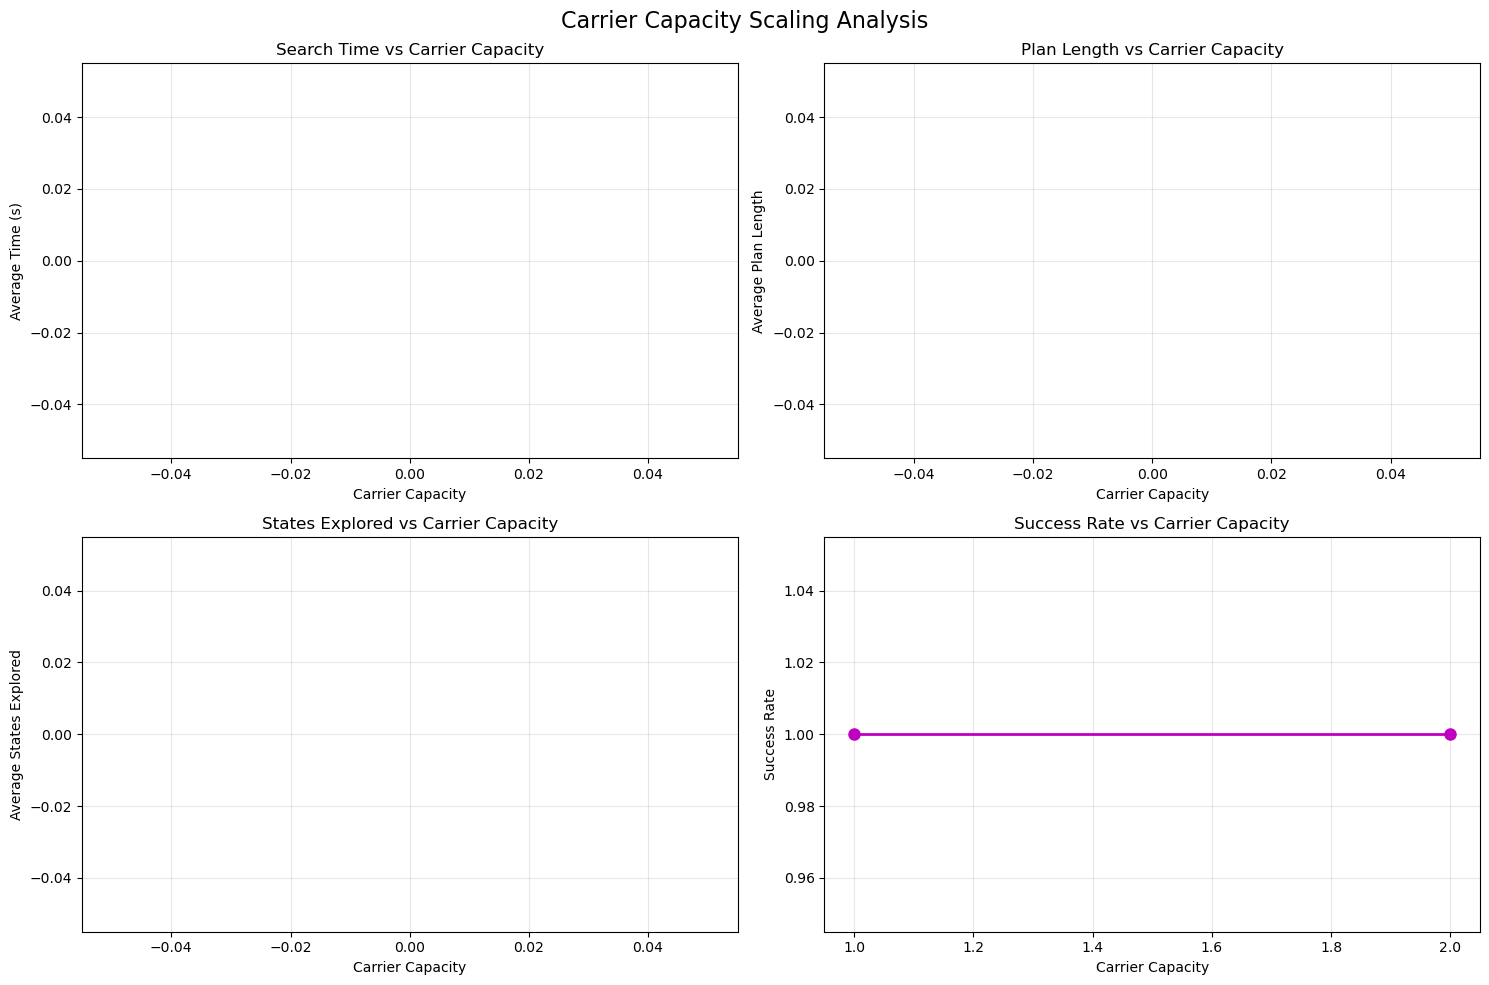


=== Statistical Analysis ===

Carrier Capacity 1:
  Problems solved: 6/6
  Average time: infs ± nans
  Average plan length: inf ± nan
  Average states: inf ± nan

Carrier Capacity 2:
  Problems solved: 4/4
  Average time: infs ± nans
  Average plan length: inf ± nan
  Average states: inf ± nan

=== Correlation Analysis ===
Correlation matrix:
                  carrier_capacity   time  plan_length  num_states
carrier_capacity             1.000 -0.391       -0.697      -0.423
time                        -0.391  1.000       -0.154       0.996
plan_length                 -0.697 -0.154        1.000      -0.131
num_states                  -0.423  0.996       -0.131       1.000

=== Optimal Carrier Capacity Analysis ===
Optimal carrier capacity for time: 1
Optimal carrier capacity for plan length: 1
Optimal carrier capacity for states explored: 1


In [11]:
# Analyze carrier capacity scaling
print("=== Carrier Capacity Scaling Analysis ===")

# Filter finite results for carrier analysis
df_carrier_finite = df_ff[df_ff['time'] != 'inf'].copy()
df_carrier_finite['time'] = pd.to_numeric(df_carrier_finite['time'])

# Group by carrier capacity and analyze performance
carrier_analysis = df_carrier_finite.groupby('carrier_capacity').agg({
    'time': ['mean', 'std', 'count'],
    'plan_length': ['mean', 'std'],
    'num_states': ['mean', 'std']
}).round(4)

print("\nPerformance by Carrier Capacity:")
print(carrier_analysis)

# Create visualization for carrier scaling
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Carrier Capacity Scaling Analysis', fontsize=16)

# Plot 1: Time vs Carrier Capacity
carrier_time = df_carrier_finite.groupby('carrier_capacity')['time'].mean()
axes[0,0].plot(carrier_time.index, carrier_time.values, 'bo-', linewidth=2, markersize=8)
axes[0,0].set_xlabel('Carrier Capacity')
axes[0,0].set_ylabel('Average Time (s)')
axes[0,0].set_title('Search Time vs Carrier Capacity')
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Plan Length vs Carrier Capacity
carrier_plan = df_carrier_finite.groupby('carrier_capacity')['plan_length'].mean()
axes[0,1].plot(carrier_plan.index, carrier_plan.values, 'ro-', linewidth=2, markersize=8)
axes[0,1].set_xlabel('Carrier Capacity')
axes[0,1].set_ylabel('Average Plan Length')
axes[0,1].set_title('Plan Length vs Carrier Capacity')
axes[0,1].grid(True, alpha=0.3)

# Plot 3: States Explored vs Carrier Capacity
carrier_states = df_carrier_finite.groupby('carrier_capacity')['num_states'].mean()
axes[1,0].plot(carrier_states.index, carrier_states.values, 'go-', linewidth=2, markersize=8)
axes[1,0].set_xlabel('Carrier Capacity')
axes[1,0].set_ylabel('Average States Explored')
axes[1,0].set_title('States Explored vs Carrier Capacity')
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Success Rate vs Carrier Capacity
success_rate = df_carrier_finite.groupby('carrier_capacity').size() / df_ff.groupby('carrier_capacity').size()
axes[1,1].plot(success_rate.index, success_rate.values, 'mo-', linewidth=2, markersize=8)
axes[1,1].set_xlabel('Carrier Capacity')
axes[1,1].set_ylabel('Success Rate')
axes[1,1].set_title('Success Rate vs Carrier Capacity')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical analysis
print("\n=== Statistical Analysis ===")
for capacity in sorted(df_carrier_finite['carrier_capacity'].unique()):
    subset = df_carrier_finite[df_carrier_finite['carrier_capacity'] == capacity]
    print(f"\nCarrier Capacity {capacity}:")
    print(f"  Problems solved: {len(subset)}/{len(df_ff[df_ff['carrier_capacity'] == capacity])}")
    print(f"  Average time: {subset['time'].mean():.4f}s ± {subset['time'].std():.4f}s")
    print(f"  Average plan length: {subset['plan_length'].mean():.1f} ± {subset['plan_length'].std():.1f}")
    print(f"  Average states: {subset['num_states'].mean():.0f} ± {subset['num_states'].std():.0f}")

# Correlation analysis
print("\n=== Correlation Analysis ===")
correlations = df_carrier_finite[['carrier_capacity', 'time', 'plan_length', 'num_states']].corr()
print("Correlation matrix:")
print(correlations.round(3))

# Optimal carrier capacity analysis
print("\n=== Optimal Carrier Capacity Analysis ===")
optimal_capacity = carrier_time.idxmin()
print(f"Optimal carrier capacity for time: {optimal_capacity}")
print(f"Optimal carrier capacity for plan length: {carrier_plan.idxmin()}")
print(f"Optimal carrier capacity for states explored: {carrier_states.idxmin()}")
